In [1]:
!pip3 install --user tensorflow=='2.0.0a0'
!pip3 install sklearn

In [2]:
import os
import joblib

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Activation, Bidirectional, Dropout, TimeDistributed
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, classification_report

np.random.seed(seed=17)

In [3]:
# Import simulation results
results = pd.read_csv('processed_results_summary.csv', keep_default_na=False)
results.head()

,Unnamed: 0,Simulation no#,Line,Load,Wind1,Wind2,Wind3,flag,Sequence,n_failures,t_fail,t_first_fail,dt_fail,failed component_type,failed_component_type,cascade,fail
0,0,1,Line 04 - 05,0.7,0.0,0.0,0.0,0,[],0,,,,,,False,False
1,18,10,Line 26 - 28,0.7,0.0,0.0,0.0,0,[],0,,,,,,False,False
2,198,100,Line 09 - 39,0.7,0.0,0.0,0.4,0,[],0,,,,,,False,False
3,1998,1000,Line 22 - 23,0.7,0.0,0.8,1.0,0,[],0,,,,,,False,False
4,19998,10000,Line 10 - 11,0.8,0.4,0.2,0.0,0,[],0,,,,,,False,False


### Data Generator

- Create a data generator to read in training, validation and test data by batches
- Model input formats:  
    x -> (batch_size, n_time_steps, n_features)  
    y -> (batch_size, 1)

In [4]:
DATA_PATH = '/output/02_preprocessed_numpy'
files = os.listdir(DATA_PATH)

In [5]:
# Get the simulation ids of sims with and without failures
fail_ids = results[results['flag']==1]['Simulation no#'].tolist()
non_fail_ids = results[results['flag']==0]['Simulation no#'].tolist()

# Randomly select fail and non-fail ids
fail_ids = np.random.choice(fail_ids, size=len(fail_ids), replace=False)
non_fail_ids = np.random.choice(non_fail_ids, size=20000, replace=False)

# Get full filepaths
paths_fail, paths_non_fail = [], []
labels_fail, labels_non_fail = [], []

for file in files:
    file_id = int(file.split('.pkl')[0])

    if file_id in fail_ids and len(paths_fail) < 3500:
        paths_fail.append(os.path.join(DATA_PATH, file))
        labels_fail.append(1)

    if file_id in non_fail_ids and len(paths_non_fail) < 3500:
        paths_non_fail.append(os.path.join(DATA_PATH, file))
        labels_non_fail.append(0)

print(len(paths_fail), len(paths_non_fail))
filepaths, labels = [None]*7000, [None]*7000
filepaths[::2], labels[::2] = paths_fail, labels_fail
filepaths[1::2], labels[1::2] = paths_non_fail, labels_non_fail

train_paths, train_labels = filepaths[:6000], labels[:6000]
val_paths, val_labels = filepaths[6000:6500], labels[6000:6500]
test_paths, test_labels = filepaths[6500:], labels[6500:]

3500 3500


In [6]:
def data_generator(batch_size, filepaths, labels, length, shift):
    count = 0
    X, y = [], []

    for file, label in zip(filepaths, labels):
        # Load simulation file as numpy array
        arr = joblib.load(os.path.join(DATA_PATH, file))

        # Windowing - create evenly sized samples
        end_index = arr.shape[0] - length

        for i in range(0, end_index, shift):
            y.append(int(label))
            X.append(arr[i:(i+length), 1:])
            count += 1

            if count >= batch_size:
                yield (np.array(X).astype(np.float32), np.array(y))
                X, y = [], []
                count = 0

In [7]:
model = tf.keras.models.load_model('model_lstm_1_layer')

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm (UnifiedLSTM)   (None, 50)                62000     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 62,051
Trainable params: 62,051
Non-trainable params: 0
_________________________________________________________________


In [9]:
type(model)

tensorflow.python.keras.engine.sequential.Sequential

### Feature importance testing

In [10]:
def permutation_importances(est, X_eval, y_eval, metric):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in range(X_eval.shape[2]):
        save = X_eval[:,:,col].copy()
        X_eval[:,:,col] = np.random.permutation(X_eval[:,:,col])
        m = metric(est, X_eval, y_eval)
        X_eval[:,:,col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    pred_y = (est.predict(X))
    acc = (np.sum(y.astype(int)[0] == pred_y.round().astype(int))) / y.shape[0]
    return acc

In [11]:
test_y, test_X = [], []

for X, y in data_generator(256, test_paths, test_labels, 100, 25):
    test_y.append(y)
    test_X.append(X)
test_y = np.concatenate(test_y)
test_X = np.concatenate(test_X)

In [12]:
test_y.shape, test_X.shape

((17920,), (17920, 100, 259))

In [13]:
accuracy_metric(model, test_X[:50, :,:], test_y[:50]) # function check

0.72

In [14]:
perm_imp = permutation_importances(model, test_X[0:1000, :,:], test_y[0:1000], accuracy_metric)

In [15]:
perm_imp

array([ 0.   ,  0.   ,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.001,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.001,  0.   ,  0.   ,  0.   ,  0.001,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.001,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.001,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.001,  0.   ,  0.001,
        0.   ,  0.   ,  0.004, -0.002, -0.001, -0.011,  0.008, -0.002,
        0.   ,  0.   ,  0.002, -0.004, -0.012,  0.   ,  0.   ,  0.   ,
       -0.001,  0.004, -0.004, -0.001,  0.   ,  0.001,  0.003,  0.003,
       -0.001,  0.   ,  0.001, -0.004,  0.002,  0.001,  0.   , -0.001,
        0.   ,  0.   , -0.001, -0.005, -0.003,  0.005,  0.   ,  0.   ,
      

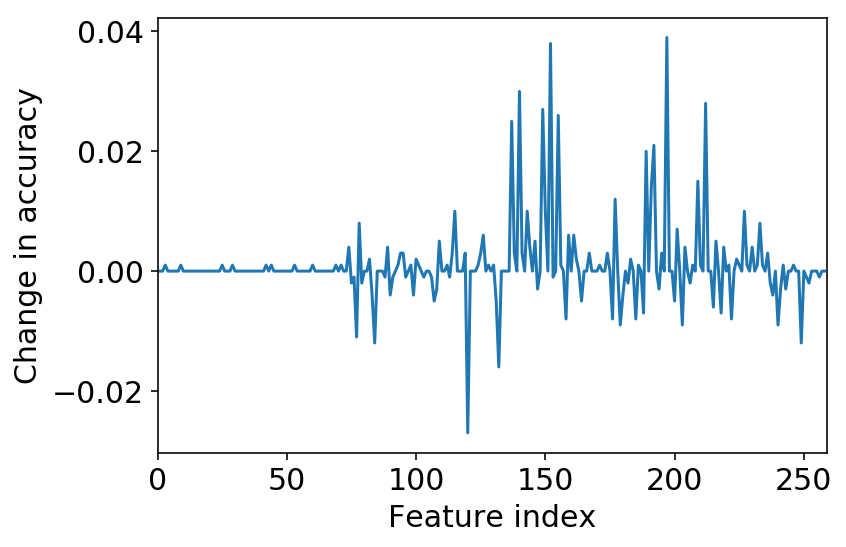

In [16]:
import matplotlib.pyplot as plt
import matplotlib

font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 15}
matplotlib.rc('font', **font)
plt.plot(perm_imp)
plt.xlabel("Feature index")
plt.xlim([0,259])
plt.ylabel("Change in accuracy")
plt.savefig('permutation_feature_importance_LSTM.pdf', dpi=200,bbox_inches='tight')
plt.show()

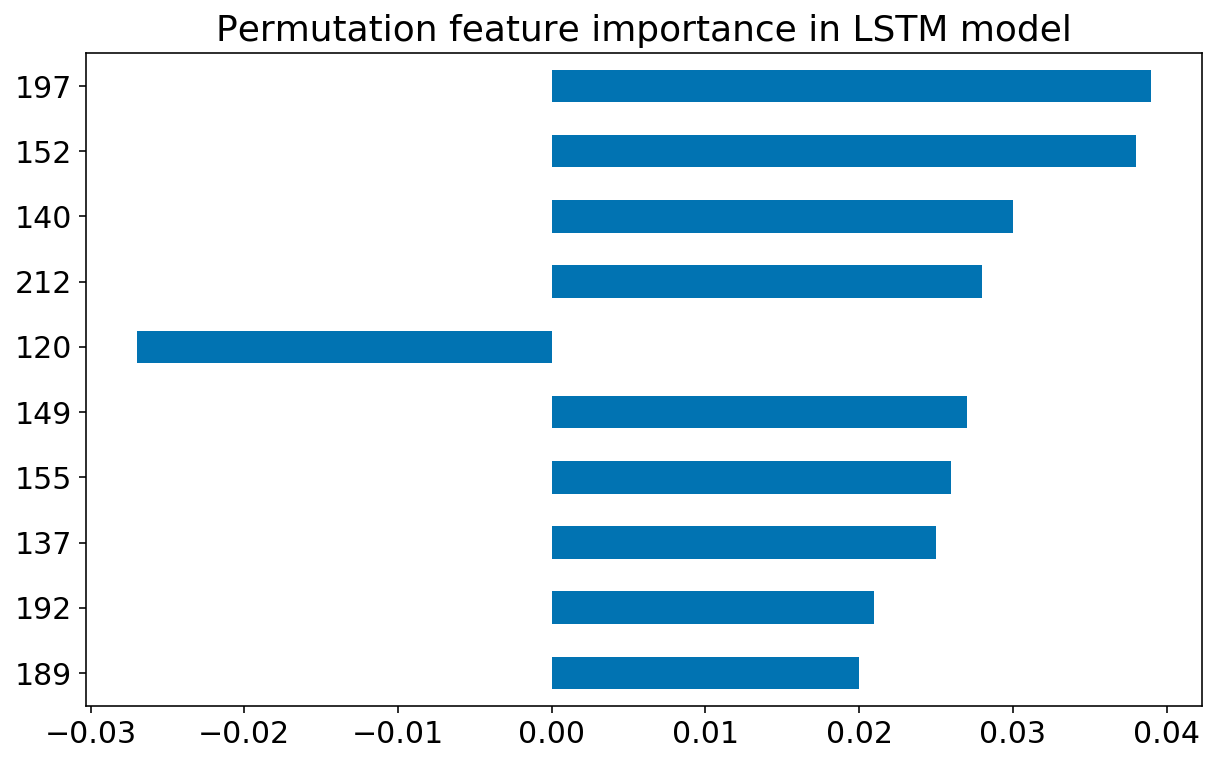

In [17]:
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

df_imp = pd.Series(perm_imp)
sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-10:].plot(kind='barh', color=sns_colors[0], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance in LSTM model')
plt.show()

In [18]:
dict_index_col= {0: 'B_L03',
 1: 'B_L03',
 2: 'B_L04',
 3: 'B_L04',
 4: 'B_L07',
 5: 'B_L07',
 6: 'B_L08',
 7: 'B_L08',
 8: 'B_L12',
 9: 'B_L12',
 10: 'B_L15',
 11: 'B_L15',
 12: 'B_L16',
 13: 'B_L16',
 14: 'B_L18',
 15: 'B_L18',
 16: 'B_L20',
 17: 'B_L20',
 18: 'B_L21',
 19: 'B_L21',
 20: 'B_L23',
 21: 'B_L23',
 22: 'B_L24',
 23: 'B_L24',
 24: 'B_L25',
 25: 'B_L25',
 26: 'B_L26',
 27: 'B_L26',
 28: 'B_L27',
 29: 'B_L27',
 30: 'B_L28',
 31: 'B_L28',
 32: 'B_L29',
 33: 'B_L29',
 34: 'Bus 01',
 35: 'Bus 02',
 36: 'Bus 03',
 37: 'Bus 04',
 38: 'Bus 05',
 39: 'Bus 06',
 40: 'Bus 07',
 41: 'Bus 08',
 42: 'Bus 09',
 43: 'Bus 10',
 44: 'Bus 11',
 45: 'Bus 12',
 46: 'Bus 13',
 47: 'Bus 14',
 48: 'Bus 15',
 49: 'Bus 16',
 50: 'Bus 17',
 51: 'Bus 18',
 52: 'Bus 19',
 53: 'Bus 20',
 54: 'Bus 21',
 55: 'Bus 22',
 56: 'Bus 23',
 57: 'Bus 24',
 58: 'Bus 25',
 59: 'Bus 26',
 60: 'Bus 27',
 61: 'Bus 28',
 62: 'Bus 29',
 63: 'Bus 30',
 64: 'Bus 31',
 65: 'Bus 32',
 66: 'Bus 33',
 67: 'Bus 34',
 68: 'Bus 35',
 69: 'Bus 36',
 70: 'Bus 37',
 71: 'Bus 38',
 72: 'Bus 39',
 73: 'Bus_NSG_1',
 74: 'Bus_NSG_2',
 75: 'Bus_NSG_3',
 76: 'G 01',
 77: 'G 01',
 78: 'G 01',
 79: 'G 01',
 80: 'G 01',
 81: 'G 01',
 82: 'G 02',
 83: 'G 02',
 84: 'G 02',
 85: 'G 02',
 86: 'G 02',
 87: 'G 02',
 88: 'G 03',
 89: 'G 03',
 90: 'G 03',
 91: 'G 03',
 92: 'G 03',
 93: 'G 03',
 94: 'G 04',
 95: 'G 04',
 96: 'G 04',
 97: 'G 04',
 98: 'G 04',
 99: 'G 04',
 100: 'G 05',
 101: 'G 05',
 102: 'G 05',
 103: 'G 05',
 104: 'G 05',
 105: 'G 05',
 106: 'G 06',
 107: 'G 06',
 108: 'G 06',
 109: 'G 06',
 110: 'G 06',
 111: 'G 06',
 112: 'G 07',
 113: 'G 07',
 114: 'G 07',
 115: 'G 07',
 116: 'G 07',
 117: 'G 07',
 118: 'G 08',
 119: 'G 08',
 120: 'G 08',
 121: 'G 08',
 122: 'G 08',
 123: 'G 08',
 124: 'G 09',
 125: 'G 09',
 126: 'G 09',
 127: 'G 09',
 128: 'G 09',
 129: 'G 09',
 130: 'G 10',
 131: 'G 10',
 132: 'G 10',
 133: 'G 10',
 134: 'G 10',
 135: 'G 10',
 136: 'Line 01 - 02',
 137: 'Line 01 - 02',
 138: 'Line 01 - 02',
 139: 'Line 01 - 39',
 140: 'Line 01 - 39',
 141: 'Line 01 - 39',
 142: 'Line 02 - 03',
 143: 'Line 02 - 03',
 144: 'Line 02 - 03',
 145: 'Line 02 - 25',
 146: 'Line 02 - 25',
 147: 'Line 02 - 25',
 148: 'Line 03 - 04',
 149: 'Line 03 - 04',
 150: 'Line 03 - 04',
 151: 'Line 03 - 18',
 152: 'Line 03 - 18',
 153: 'Line 03 - 18',
 154: 'Line 04 - 05',
 155: 'Line 04 - 05',
 156: 'Line 04 - 05',
 157: 'Line 04 - 14',
 158: 'Line 04 - 14',
 159: 'Line 04 - 14',
 160: 'Line 05 - 06',
 161: 'Line 05 - 06',
 162: 'Line 05 - 06',
 163: 'Line 05 - 08',
 164: 'Line 05 - 08',
 165: 'Line 05 - 08',
 166: 'Line 06 - 07',
 167: 'Line 06 - 07',
 168: 'Line 06 - 07',
 169: 'Line 06 - 11',
 170: 'Line 06 - 11',
 171: 'Line 06 - 11',
 172: 'Line 07 - 08',
 173: 'Line 07 - 08',
 174: 'Line 07 - 08',
 175: 'Line 08 - 09',
 176: 'Line 08 - 09',
 177: 'Line 08 - 09',
 178: 'Line 09 - 39',
 179: 'Line 09 - 39',
 180: 'Line 09 - 39',
 181: 'Line 10 - 11',
 182: 'Line 10 - 11',
 183: 'Line 10 - 11',
 184: 'Line 10 - 13',
 185: 'Line 10 - 13',
 186: 'Line 10 - 13',
 187: 'Line 13 - 14',
 188: 'Line 13 - 14',
 189: 'Line 13 - 14',
 190: 'Line 14 - 15',
 191: 'Line 14 - 15',
 192: 'Line 14 - 15',
 193: 'Line 15 - 16',
 194: 'Line 15 - 16',
 195: 'Line 15 - 16',
 196: 'Line 16 - 17',
 197: 'Line 16 - 17',
 198: 'Line 16 - 17',
 199: 'Line 16 - 19',
 200: 'Line 16 - 19',
 201: 'Line 16 - 19',
 202: 'Line 16 - 21',
 203: 'Line 16 - 21',
 204: 'Line 16 - 21',
 205: 'Line 16 - 24',
 206: 'Line 16 - 24',
 207: 'Line 16 - 24',
 208: 'Line 17 - 18',
 209: 'Line 17 - 18',
 210: 'Line 17 - 18',
 211: 'Line 17 - 27',
 212: 'Line 17 - 27',
 213: 'Line 17 - 27',
 214: 'Line 21 - 22',
 215: 'Line 21 - 22',
 216: 'Line 21 - 22',
 217: 'Line 22 - 23',
 218: 'Line 22 - 23',
 219: 'Line 22 - 23',
 220: 'Line 23 - 24',
 221: 'Line 23 - 24',
 222: 'Line 23 - 24',
 223: 'Line 25 - 26',
 224: 'Line 25 - 26',
 225: 'Line 25 - 26',
 226: 'Line 26 - 27',
 227: 'Line 26 - 27',
 228: 'Line 26 - 27',
 229: 'Line 26 - 28',
 230: 'Line 26 - 28',
 231: 'Line 26 - 28',
 232: 'Line 26 - 29',
 233: 'Line 26 - 29',
 234: 'Line 26 - 29',
 235: 'Line 28 - 29',
 236: 'Line 28 - 29',
 237: 'Line 28 - 29',
 238: 'NSG_1',
 239: 'NSG_1',
 240: 'NSG_2',
 241: 'NSG_3',
 242: 'Trf Load_03',
 243: 'Trf Load_04',
 244: 'Trf Load_07',
 245: 'Trf Load_08',
 246: 'Trf Load_12',
 247: 'Trf Load_15',
 248: 'Trf Load_16',
 249: 'Trf Load_18',
 250: 'Trf Load_20',
 251: 'Trf Load_21',
 252: 'Trf Load_23',
 253: 'Trf Load_24',
 254: 'Trf Load_25',
 255: 'Trf Load_26',
 256: 'Trf Load_27',
 257: 'Trf Load_28',
 258: 'Trf Load_29'}

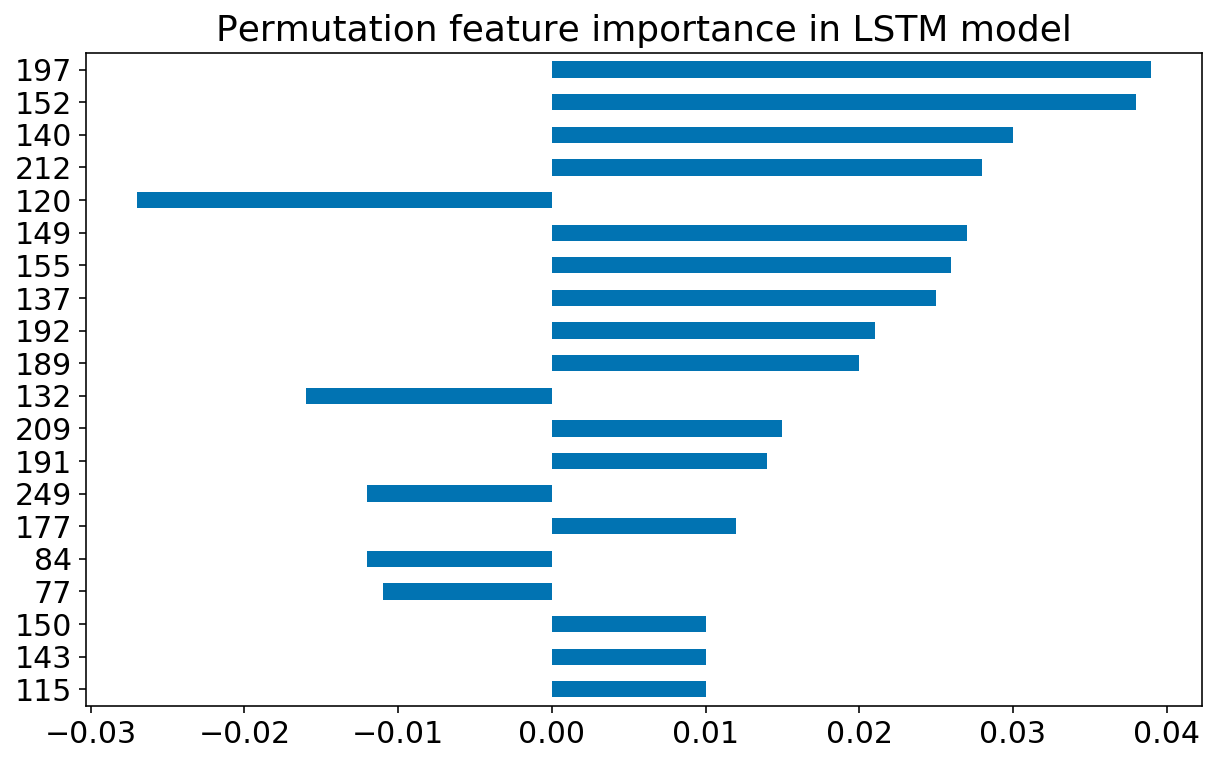

In [19]:
df_imp = pd.Series(perm_imp)
sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-20:].plot(kind='barh', color=sns_colors[0], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance in LSTM model')
plt.show()

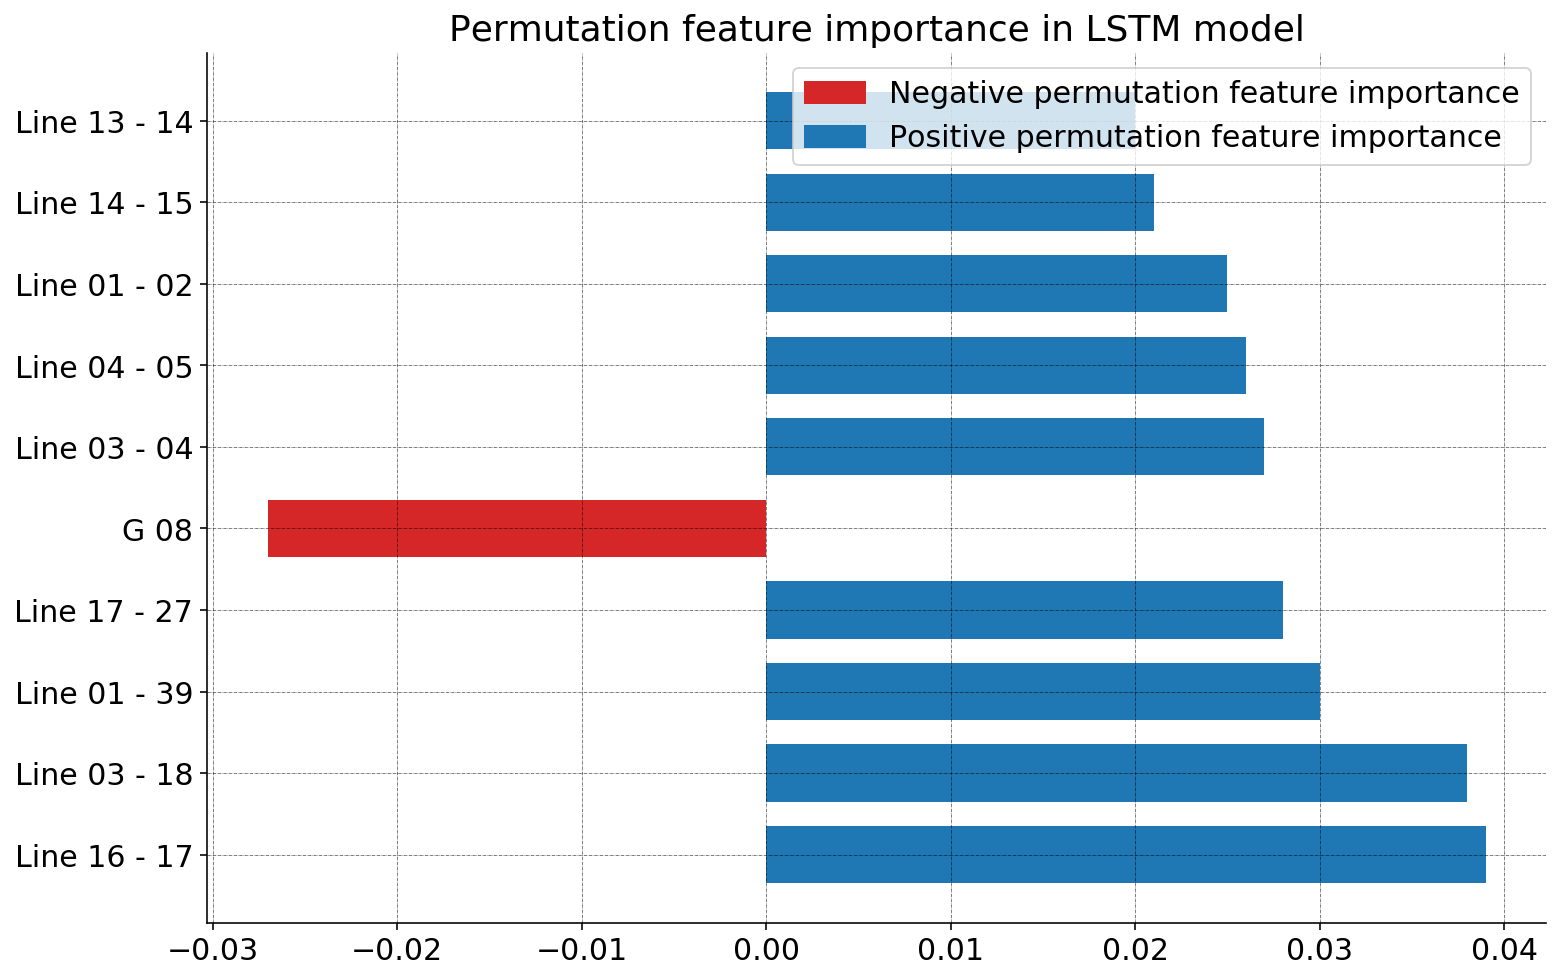

In [20]:
import matplotlib.patches as mpatches

imp = {
    'Line 16 - 17': 0.039,
    'Line 03 - 18': 0.038,
    'Line 01 - 39': 0.030,
    'Line 17 - 27': 0.028,
    'G 08': -0.027,
    'Line 03 - 04': 0.027,
    'Line 04 - 05': 0.026,
    'Line 01 - 02': 0.025,
    'Line 14 - 15': 0.021,
    'Line 13 - 14': 0.020
}

def get_color(value):
    blue, red = sns.color_palette()[0], sns.color_palette()[3]
    if value >= 0: return blue
    return red

patch_1 = mpatches.Patch(color=sns.color_palette()[3], label='Negative permutation feature importance')
patch_2 = mpatches.Patch(color=sns.color_palette()[0], label='Positive permutation feature importance')

fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(imp))
width = 0.7
delta_loss = [v for v in imp.values()]
colors = [get_color(x) for x in delta_loss]
plt.barh(x, delta_loss, width, color=colors)
plt.grid(color='k', ls = '-.', lw = 0.25)
plt.yticks(x, imp.keys())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Permutation feature importance in LSTM model')
_= plt.legend(handles=[patch_1,patch_2])

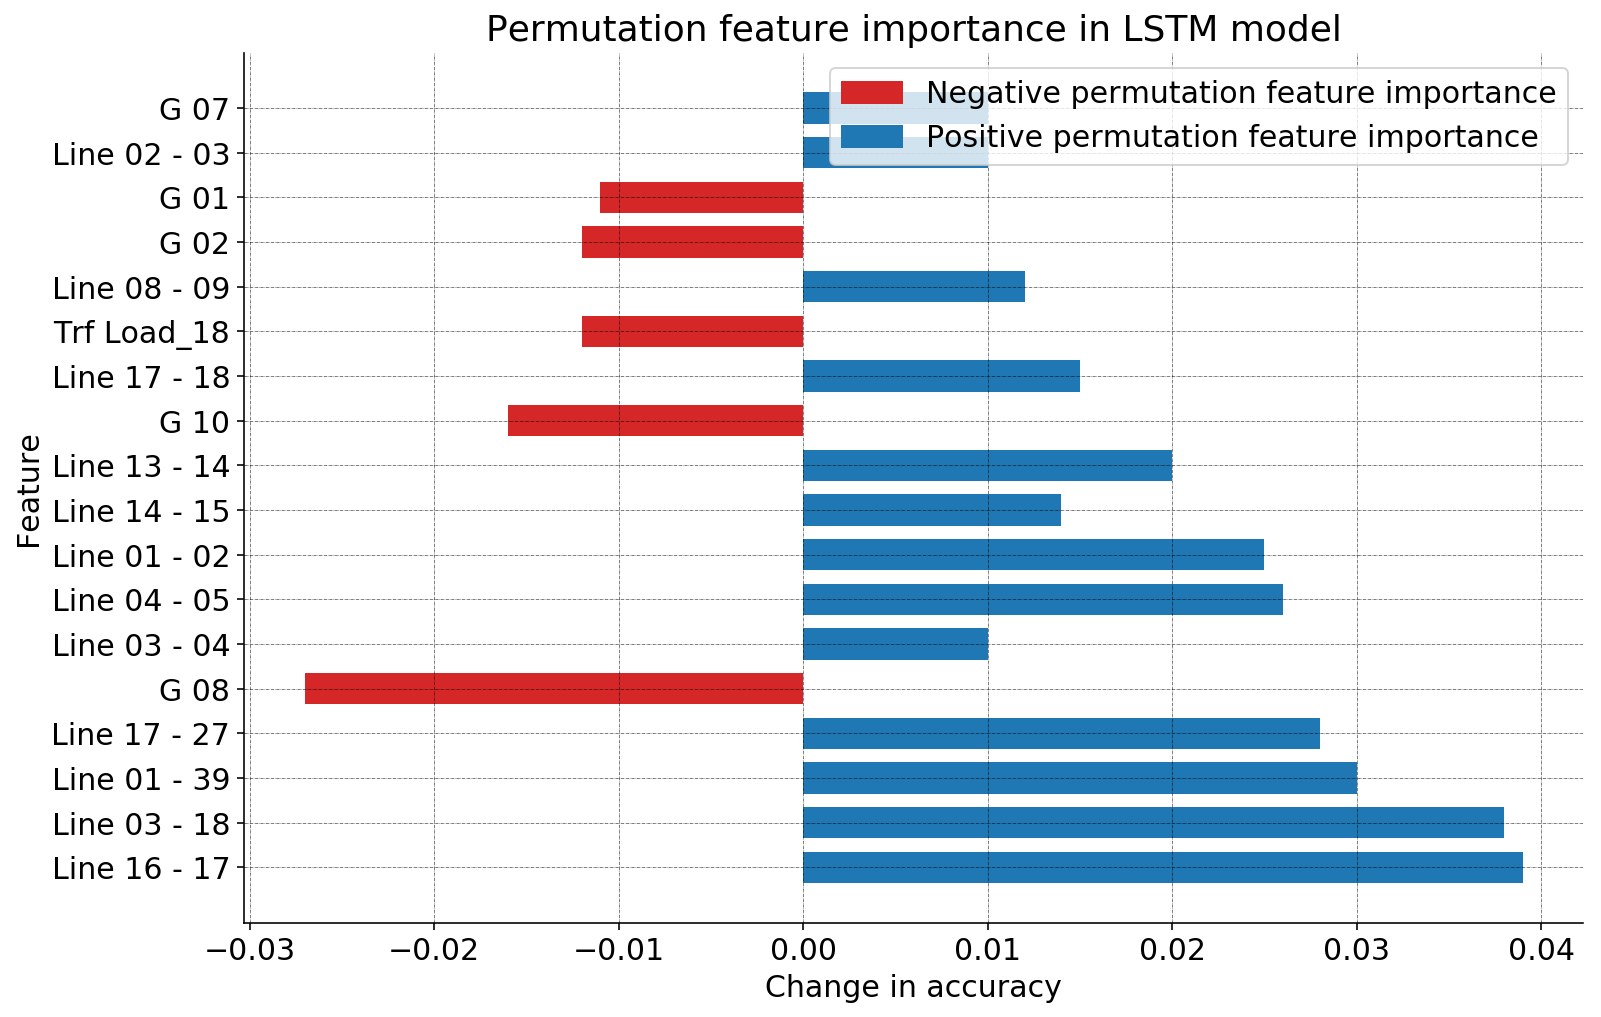

In [22]:
import matplotlib.patches as mpatches

imp = {
    'Line 16 - 17': 0.039,
    'Line 03 - 18': 0.038,
    'Line 01 - 39': 0.030,
    'Line 17 - 27': 0.028,
    'G 08': -0.027,
    'Line 03 - 04': 0.027,
    'Line 04 - 05': 0.026,
    'Line 01 - 02': 0.025,
    'Line 14 - 15': 0.021,
    'Line 13 - 14': 0.020,
    'G 10': -0.016,
    'Line 17 - 18': 0.015,
    'Line 14 - 15': 0.014,
    'Trf Load_18': -0.012,
    'Line 08 - 09': 0.012,
    'G 02': -0.012,
    'G 01': -0.011,
    'Line 03 - 04': 0.010,
    'Line 02 - 03':0.010,
    'G 07': 0.010
}

def get_color(value):
    blue, red = sns.color_palette()[0], sns.color_palette()[3]
    if value >= 0: return blue
    return red

patch_1 = mpatches.Patch(color=sns.color_palette()[3], label='Negative permutation feature importance')
patch_2 = mpatches.Patch(color=sns.color_palette()[0], label='Positive permutation feature importance')

fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(imp))
width = 0.7
delta_loss = [v for v in imp.values()]
colors = [get_color(x) for x in delta_loss]
plt.barh(x, delta_loss, width, color=colors)
plt.grid(color='k', ls = '-.', lw = 0.25)
plt.yticks(x, imp.keys())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("Change in accuracy")
plt.ylabel("Feature")
ax.set_title('Permutation feature importance in LSTM model')
_= plt.legend(handles=[patch_1,patch_2])